In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import random
import os
import time
import math
from math import sqrt

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import statsmodels.api as sm

import copy
from tqdm import tqdm

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cuda


In [9]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
def metric(y_test, y_hat, log=False):
    MSE  = mean_squared_error(y_test, y_hat)
    RMSE = sqrt(MSE)
    MAE  = mean_absolute_error(y_test, y_hat)
    MAPE = mean_absolute_percentage_error(y_test, y_hat)
    R2   = r2_score(y_test, y_hat)
    
    if log:
        print(f'\
MSE...............{MSE:.4f}\n\
RMSE..............{RMSE:.4f}\n\
MAE...............{MAE:.4f}\n\
MAPE..............{MAPE:.4f}\n\
R2................{R2:.4f}\
              ')
    
    return [MSE, RMSE, MAE, MAPE, R2]

In [11]:
# # # отсчет времени # # #

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# # # подготовка данных # # #

def sliding_window(ts, features, shift=1):
    X, Y = [], []
    for i in range(features + 1, len(ts) + 1 - shift):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i - 1 + shift]])
    return np.array(X), np.array(Y)


def lagging_var(data, var, lags_list):
    lagged_df = data.copy()
    for name, lags in zip(var, lags_list):
        for lag in lags:
            if lag > 0: 
                lagged_df[name + '_L' + str(lag)] = lagged_df[name].shift(lag)
    lagged_df = lagged_df.fillna(0)
    return lagged_df

def unscale(data, dim, scaler):
    trainPredict_dataset_like = np.zeros(shape=(len(data), dim))
    trainPredict_dataset_like[:,0] = data[:,0]
    trainPredict = scaler.inverse_transform(trainPredict_dataset_like)[:,0]
    return trainPredict

test = np.arange(0,100)
x,y = sliding_window(ts=test, features=24, shift=24)
print('x=',x[0])
print('y=',y[0])

x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
y= [48]


In [12]:
# загрузка датасета
file_name = 'experiment_rsv'

try:
    df = pd.read_pickle(f"DATASET\\{file_name}.pkl")
except:
    df = pd.read_csv("/content/Kemerovo_energy.csv") 
    df = df.set_index(df.columns[0])
    
df['ats'] = df['ats'].rolling(5).mean()
df['rsv'] = df['rsv'].rolling(5).mean()

df = df.drop(columns=['load_actual_sobr', 'generate_actual_sobr']).dropna()
df

,rsv,ats,price,month,day,day_of_week,year,index,workday,weekend,shortday,holiday,T2M,load_planned_sobr,generate_planned_sobr
2014-01-01 04:00:00,717.123975,713.511987,1848.560059,1.0,1.0,2.0,2014.0,4.0,0.0,0.0,0.0,1.0,-10.310000,3518.000000,2255.000000
2014-01-01 05:00:00,715.164868,709.313989,1845.310059,1.0,1.0,2.0,2014.0,5.0,0.0,0.0,0.0,1.0,-10.420000,3586.000000,2255.000000
2014-01-01 06:00:00,716.528381,709.229980,1854.349976,1.0,1.0,2.0,2014.0,6.0,0.0,0.0,0.0,1.0,-10.510000,3520.000000,2204.000000
2014-01-01 07:00:00,717.919177,709.481982,1847.910034,1.0,1.0,2.0,2014.0,7.0,0.0,0.0,0.0,1.0,-10.600000,3528.000000,2178.000000
2014-01-01 08:00:00,721.534302,713.453992,1861.369995,1.0,1.0,2.0,2014.0,8.0,0.0,0.0,0.0,1.0,-10.740000,3517.000000,2219.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,1243.473633,1488.076025,3644.979980,7.0,31.0,6.0,2022.0,73003.0,0.0,1.0,0.0,0.0,17.730000,3164.051025,2015.900024
2022-07-31 20:00:00,1224.521216,1499.180005,3627.510010,7.0,31.0,6.0,2022.0,73004.0,0.0,1.0,0.0,0.0,17.280001,3087.885010,2025.900024
2022-07-31 21:00:00,1196.097412,1489.583984,3529.770020,7.0,31.0,6.0,2022.0,73005.0,0.0,1.0,0.0,0.0,16.889999,3038.926025,1995.900024
2022-07-31 22:00:00,1152.519214,1449.439990,3393.550049,7.0,31.0,6.0,2022.0,73006.0,0.0,1.0,0.0,0.0,16.690001,3041.237061,1995.900024


In [13]:
class RNN(nn.Module):

    def __init__(self, hidden_size, RNN_cell, in_size=1, out_size=1, bidirectional=False, dropout=0, num_layers=1):
        super(RNN, self).__init__()
        
        self.lstm = RNN_cell(input_size=in_size, 
                             hidden_size=hidden_size, 
                             batch_first=True, 
                             bidirectional=bidirectional,
                             num_layers=num_layers)
        n = 2 if bidirectional else 1
        self.fc      = nn.Linear(hidden_size*n, out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        out = self.dropout(out)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, h

In [14]:
def train(num_epochs, model, dataset_train, dataset_val, optimizer, criterion, scaler, feature_dim, step_size,
          iter_log=10, show_plot=False, lr_scheduler=None, patience=200, one_line_log=False):
    start = time.time()
    train_loss_list, val_loss_list = [], []
    best_loss, best_acc = 999, 999
    no_improvement, no_increase = 0, 0
    early_stopping_increment = 1
    prev_test_loss = 999
    
    try:
        for epoch in range(1, num_epochs+1):
            model.train()
            train_loss = .0
            yhat, yact = [], []
            for x, y in dataset_train:
                y_pred, _ = model(x.to(device)) 
                loss = criterion(y_pred, y.to(device))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_loss += loss.item()
                yhat.append(y_pred.detach().cpu())
                yact.append(y.detach().cpu())
            yhat = [element.tolist() for sublist in yhat for element in sublist]
            yact = [element.tolist() for sublist in yact for element in sublist]
            train_acc = metric(unscale(np.array(yact), feature_dim, scaler), 
                               unscale(np.array(yhat), feature_dim, scaler))[1] #RMSE
            train_loss_list.append(train_loss)

            model.eval()
            test_loss = .0
            yhat, yact = [], []
            with torch.no_grad():
                for x, y in dataset_val:
                    y_pred, _ = model(x.to(device))
                    vall_loss = criterion(y_pred, y.to(device))
                    test_loss += vall_loss.item()
                    yhat.append(y_pred.detach().cpu())
                    yact.append(y.detach().cpu())
                yhat = [element.tolist() for sublist in yhat for element in sublist]
                yact = [element.tolist() for sublist in yact for element in sublist]
                test_acc = metric(unscale(np.array(yact), feature_dim, scaler), 
                                  unscale(np.array(yhat), feature_dim, scaler))[1] #RMSE
                val_loss_list.append(test_loss)
                
                lr_scheduler.step(test_loss)

            if (epoch > 1) and val_loss_list[-2] < val_loss_list[-1]:
                no_increase += 1
            else:
                no_increase = 0
            
            if no_increase < 20:
                early_stopping_increment = 1
            elif no_increase < 40:
                early_stopping_increment = 2
            else:
                early_stopping_increment = 3
            
            if test_loss < best_loss:
                best_loss = test_loss
                best_model = copy.deepcopy(model.state_dict())
                no_improvement -= 10
                no_improvement = 0 if no_improvement < 0 else no_improvement
            else:
                no_improvement += early_stopping_increment
            
            if test_acc < best_acc:
                best_acc  = test_acc
                                            
            if epoch % iter_log == 0:
                if one_line_log:
                    print(f"Epoch: {epoch}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, test acc: {test_acc:.2f}, best acc: {best_acc:.2f}, time: {timeSince(start, epoch/num_epochs)}, no improv.: {no_improvement}", end="")
                    print("\r", end="")
                else:
                    print(f"Epoch: {epoch}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, test acc: {test_acc:.2f}, best acc: {best_acc:.2f}, time: {timeSince(start, epoch/num_epochs)}, no improv.: {no_improvement}")
                                   
            if no_improvement >= patience:
                print(f'Early stop at {epoch} epoch')
                break
        
    except KeyboardInterrupt:
        print(f'Interrupted at {epoch} epoch')
        
    model.load_state_dict(best_model)
    
    if show_plot:
        plt.plot(train_loss_list[10:], c='tab:blue')
        plt.gca().twinx().plot(val_loss_list[10:], label='val', c='tab:red')
        plt.title(f'best acc - {best_acc:.4f}, best loss - {best_loss:.4f}')
        plt.legend()
        plt.show()
    
    return model


def batch_predict(model, dataloader):
    model.eval()
    yhat, yact = [], []
    with torch.no_grad():
        for x, y in dataloader:
            y_pred, _ = model(x.to(device))
            yhat.append(y_pred.detach().cpu())
            yact.append(y.detach().cpu())
        yhat = [element.tolist() for sublist in yhat for element in sublist]
        yact = [element.tolist() for sublist in yact for element in sublist]
    return np.array(yact), np.array(yhat)

In [15]:
def data_prep(features, val_len=0.2, test_len=720, seq_length=720, shift=1, batch_size=256, print_shapes=False):
    data = features.copy().to_numpy()
    test_len += seq_length + shift

    train_val_data = data[:len(data) - test_len]
    test_data      = data[len(data) - test_len:]
    train_data     = train_val_data[:int(len(train_val_data)*(1-val_len))]
    val_data       = train_val_data[int(len(train_val_data)*(1-val_len)):]

    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(train_val_data)
    train_data = scaler.transform(train_data)
    test_data  = scaler.transform(test_data)
    val_data   = scaler.transform(val_data)

    X_train, y_train = sliding_window(train_data, seq_length, shift)
    X_val, y_val     = sliding_window(val_data, seq_length, shift)
    X_test, y_test   = sliding_window(test_data, seq_length, shift)

    dataset_train = DataLoader(TensorDataset(torch.Tensor(X_train), 
                                             torch.Tensor(y_train)[:,:,0]), 
                               batch_size=batch_size, shuffle=False)
    dataset_val  = DataLoader(TensorDataset(torch.Tensor(X_val),  
                                            torch.Tensor(y_val)[:,:,0]),  
                              batch_size=batch_size, shuffle=False)
    dataset_test  = DataLoader(TensorDataset(torch.Tensor(X_test),  
                                            torch.Tensor(y_test)[:,:,0]),  
                              batch_size=batch_size, shuffle=False)
    
    feature_dim = X_train.shape[2]
    
    if print_shapes:
        print('Train data shape:')
        print(f'X_train -> {X_train.shape}')
        print(f'y_train -> {y_train.shape}')
        print('Val data shape:')
        print(f'X_val -> {X_val.shape}')
        print(f'y_val -> {y_val.shape}')
        print('Test data shape:')
        print(f'X_test -> {X_test.shape}')
        print(f'y_test -> {y_test.shape}')
        
    return dataset_train, dataset_val, dataset_test, scaler, feature_dim

### Один запуск

Early stop at 272 epoch 3.5682, test loss: 1.4283, test acc: 152.35, best acc: 151.33, time: 7m 15s (- 126m 16s), no improv.: 80


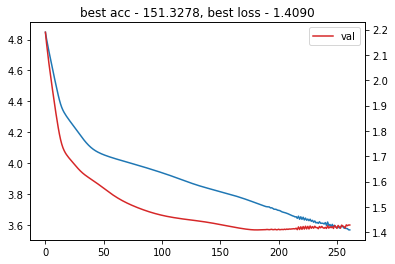

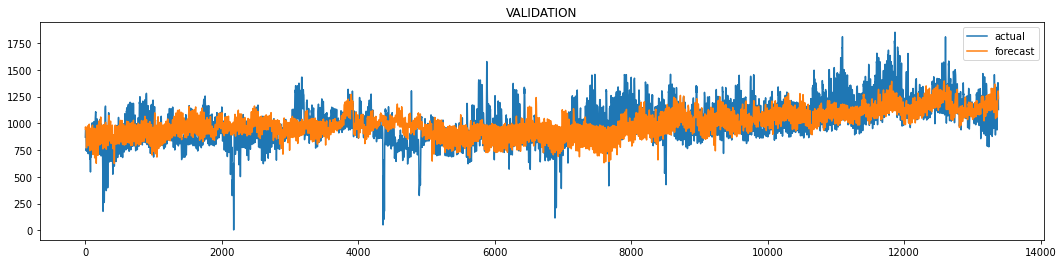

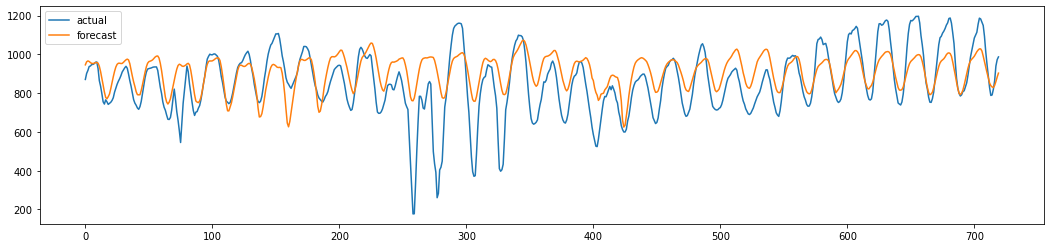

MSE...............22900.1122
RMSE..............151.3278
MAE...............113.1343
MAPE..............0.1572
R2................0.4419              


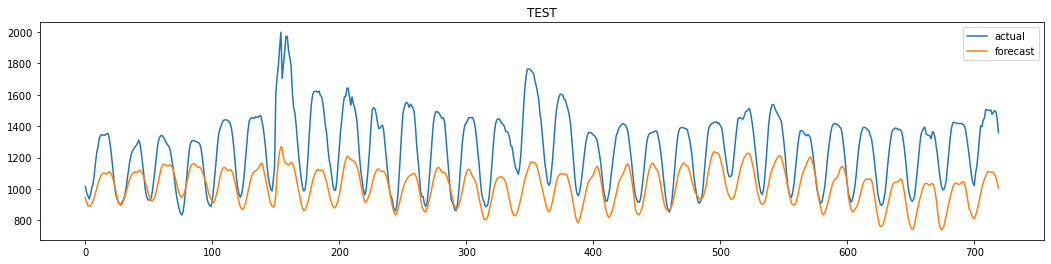

MSE...............80590.2630
RMSE..............283.8842
MAE...............242.9176
MAPE..............0.1812
R2................-0.6392              


In [22]:
dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=df[['ats', 'index', 'load_planned_sobr', 'day_of_week', 'day']], 
                                                                              val_len=0.2, 
                                                                              test_len=720, 
                                                                              seq_length=168, 
                                                                              shift=720, 
                                                                              batch_size=256,
                                                                              print_shapes=False)

seed_everything(SEED)

num_epochs    = 5000
learning_rate = 3e-4
pat = 80
iter_log = 1
show_plot = True

model = RNN(RNN_cell=nn.LSTM,
            hidden_size=12,
            num_layers=1,
            dropout=0,
            in_size=feature_dim, 
            out_size=1, 
            bidirectional=False).to(device)

criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=9999, min_lr=1e-5)

best_model = copy.deepcopy(model.state_dict())

model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
              dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
              lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
              iter_log=iter_log, show_plot=show_plot, step_size=None, one_line_log=True)

# # #

model.eval()
y_act, y_hat = batch_predict(model=model, dataloader=dataset_val)
y_hat = unscale(y_hat, feature_dim, scaler)
y_act = unscale(y_act, feature_dim, scaler)
plt.figure(figsize=(18,4))
plt.plot(y_act, label='actual')
plt.plot(y_hat, label='forecast')
plt.legend()
plt.title(f'VALIDATION')
plt.show()
plt.figure(figsize=(18,4))
plt.plot(y_act[:720], label='actual')
plt.plot(y_hat[:720], label='forecast')
plt.legend()
plt.show()

metric(y_act, y_hat, log=True);

# # #

y_act, y_hat = batch_predict(model=model, dataloader=dataset_test)
y_hat = unscale(y_hat, feature_dim, scaler)
y_act = unscale(y_act, feature_dim, scaler)
plt.figure(figsize=(18,4))
plt.plot(y_act, label='actual')
plt.plot(y_hat, label='forecast')
plt.legend()
plt.title(f'TEST')
plt.show()

metric(y_act, y_hat, log=True);

In [23]:
pd.DataFrame({'yact' : y_act, 'yhat' : y_hat}).to_pickle(f"DATASET\\LSTM.pkl")

### Итерировать по seq_len

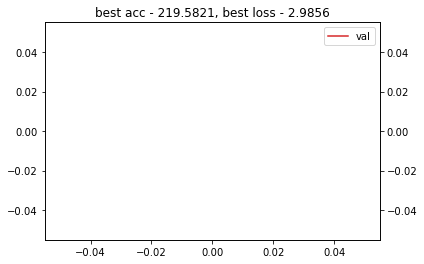

MSE...............48216.2978
RMSE..............219.5821
MAE...............168.7650
MAPE..............0.1950
R2................-0.1749              


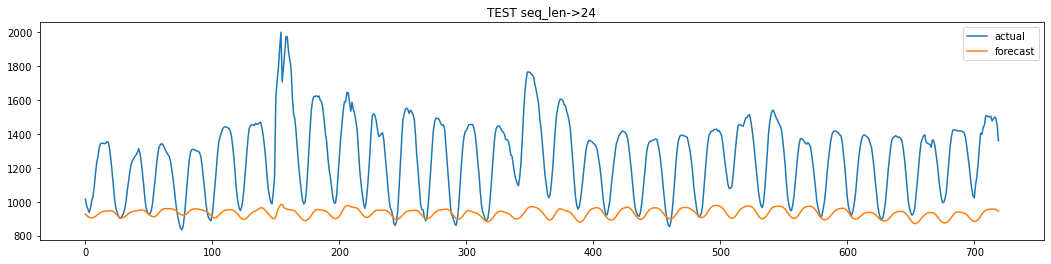

MSE...............146993.4403
RMSE..............383.3972
MAE...............325.7631
MAPE..............0.2386
R2................-1.9899              


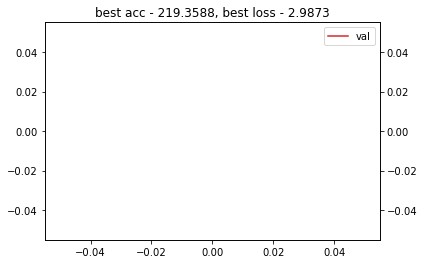

MSE...............48118.2743
RMSE..............219.3588
MAE...............168.5773
MAPE..............0.1950
R2................-0.1704              


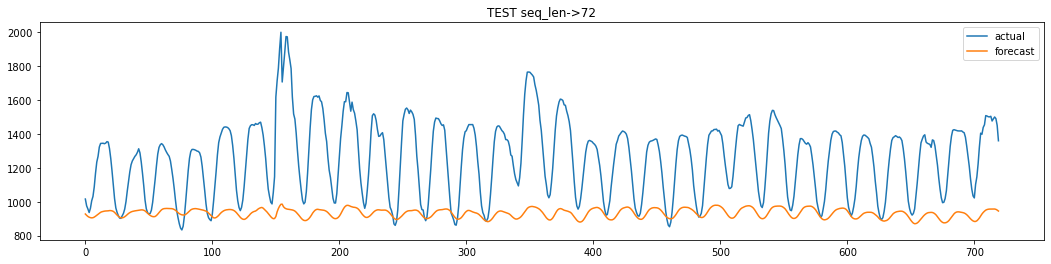

MSE...............146514.4813
RMSE..............382.7721
MAE...............325.2013
MAPE..............0.2382
R2................-1.9802              


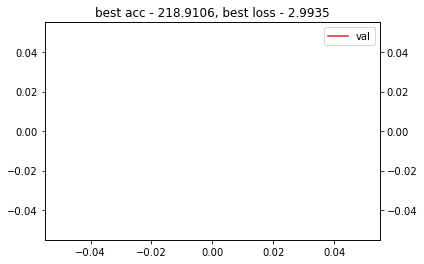

MSE...............47921.8339
RMSE..............218.9106
MAE...............168.0581
MAPE..............0.1950
R2................-0.1679              


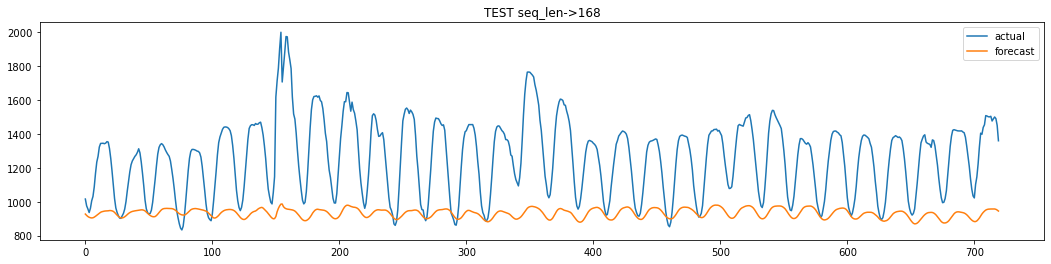

MSE...............146427.2296
RMSE..............382.6581
MAE...............325.2241
MAPE..............0.2382
R2................-1.9784              
Interrupted at 1 epoch


UnboundLocalError: local variable 'best_model' referenced before assignment

In [15]:
seq_len = [24, 24*3, 24*7, 24*14, 24*30, 24*60]

val_results, test_results = {}, {}

for seq_length in seq_len:
    iter_name = f'seq_len->{seq_length}'
    
    dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=df[['ats']], 
                                                                              val_len=0.2, 
                                                                              test_len=720, 
                                                                              seq_length=seq_length, 
                                                                              shift=720, 
                                                                              batch_size=256,
                                                                              print_shapes=False)

    seed_everything(SEED)

    num_epochs    = 2000
    learning_rate = 1e-3
    input_size    = feature_dim
    pat = 80
    iter_log = 1
    show_plot = True

    model = RNN(RNN_cell=nn.LSTM,
                hidden_size=24,
                num_layers=1,
                dropout=0,
                in_size=input_size, 
                out_size=1, 
                bidirectional=False).to(device)

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=9999, min_lr=1e-5)

    best_model = copy.deepcopy(model.state_dict())

    model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
                  dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
                  lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
                  iter_log=iter_log, show_plot=show_plot, step_size=None, one_line_log=True)

    # # #

    model.eval()
    y_act, y_hat = batch_predict(model=model, dataloader=dataset_val)
    y_hat = unscale(y_hat, feature_dim, scaler)
    y_act = unscale(y_act, feature_dim, scaler)

    val_scores = metric(y_act, y_hat, log=True)

    # # #

    y_act, y_hat = batch_predict(model=model, dataloader=dataset_test)
    y_hat = unscale(y_hat, feature_dim, scaler)
    y_act = unscale(y_act, feature_dim, scaler)
    plt.figure(figsize=(18,4))
    plt.plot(y_act, label='actual')
    plt.plot(y_hat, label='forecast')
    plt.legend()
    plt.title(f'TEST {iter_name}')
    plt.show()

    test_scores = metric(y_act, y_hat, log=True)
    
    val_results.update({iter_name : val_scores})
    test_results.update({iter_name : test_scores})

for key, value in val_results.items():
    print(key, '....', [round(x,2) for x in value])
print('\n')
for key, value in test_results.items():
    print(key, '....', [round(x,2) for x in value])

seq_len->24 .... [29087.93, 170.55, 129.11, 0.16, 0.29]
seq_len->72 .... [29146.35, 170.72, 129.29, 0.16, 0.29]
seq_len->168 .... [27709.52, 166.46, 125.36, 0.16, 0.32]
seq_len->336 .... [29378.51, 171.4, 129.71, 0.16, 0.29]
seq_len->720 .... [29782.36, 172.58, 130.35, 0.17, 0.28]
seq_len->1440 .... [28305.09, 168.24, 126.01, 0.17, 0.28]


seq_len->24 .... [75493.21, 274.76, 233.85, 0.17, -0.54]
seq_len->72 .... [75428.61, 274.64, 233.85, 0.17, -0.53]
seq_len->168 .... [72233.8, 268.76, 228.03, 0.17, -0.47]
seq_len->336 .... [74799.86, 273.5, 232.8, 0.17, -0.52]
seq_len->720 .... [74376.86, 272.72, 232.11, 0.17, -0.51]
seq_len->1440 .... [79628.36, 282.18, 238.38, 0.18, -0.62]


### Итерирование по гиперпараметрам

Train data shape:
X_train -> (56195, 168, 5)
y_train -> (56195, 1, 5)
Val data shape:
X_val -> (13383, 168, 5)
y_val -> (13383, 1, 5)
Test data shape:
X_test -> (720, 168, 5)
y_test -> (720, 1, 5)


hs=12, lr=0.003
Early stop at 94 epoch 3.6498, test loss: 2.3010, test acc: 192.43, best acc: 159.09, time: 2m 29s (- 129m 54s), no improv.: 81


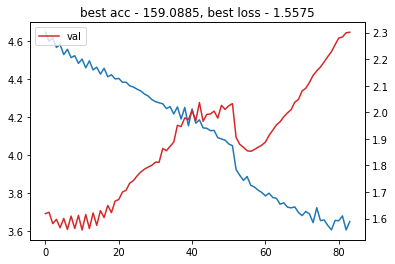

iter-12-0.003 ->
MSE...............25309.1383
RMSE..............159.0885
MAE...............119.2844
MAPE..............0.1582
R2................0.3832              


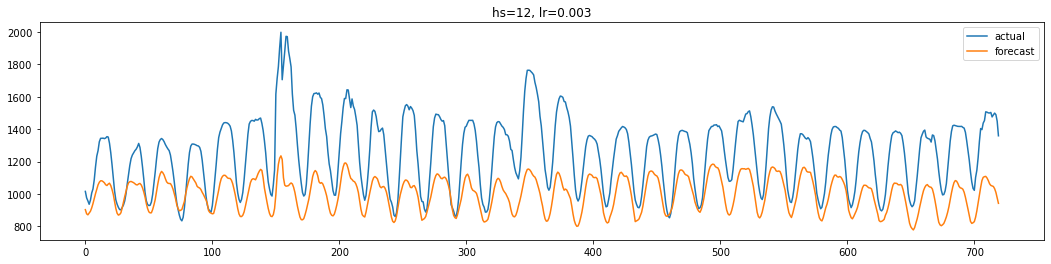

MSE...............86832.6196
RMSE..............294.6738
MAE...............255.2621
MAPE..............0.1905
R2................-0.7662              
hs=12, lr=0.001
Early stop at 134 epoch 3.5431, test loss: 1.8553, test acc: 173.61, best acc: 153.99, time: 3m 34s (- 129m 31s), no improv.: 80


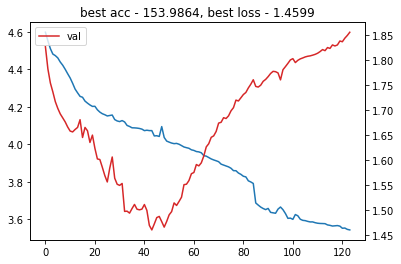

iter-12-0.001 ->
MSE...............23711.8207
RMSE..............153.9864
MAE...............115.2380
MAPE..............0.1556
R2................0.4221              


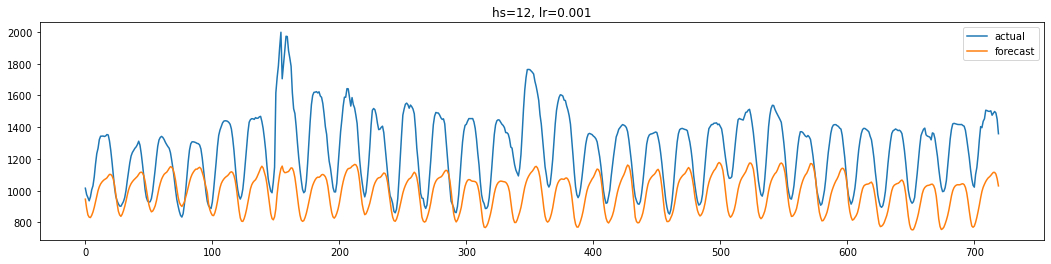

MSE...............94948.7030
RMSE..............308.1375
MAE...............268.8372
MAPE..............0.2025
R2................-0.9313              
hs=12, lr=0.0003
Early stop at 272 epoch 3.5290, test loss: 1.4257, test acc: 152.21, best acc: 151.33, time: 7m 15s (- 126m 2s), no improv.: 800


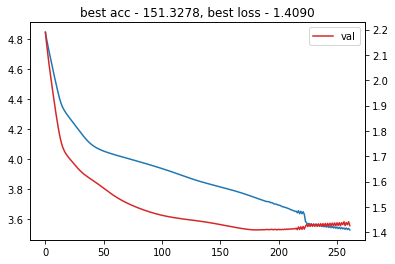

iter-12-0.0003 ->
MSE...............22900.1122
RMSE..............151.3278
MAE...............113.1343
MAPE..............0.1572
R2................0.4419              


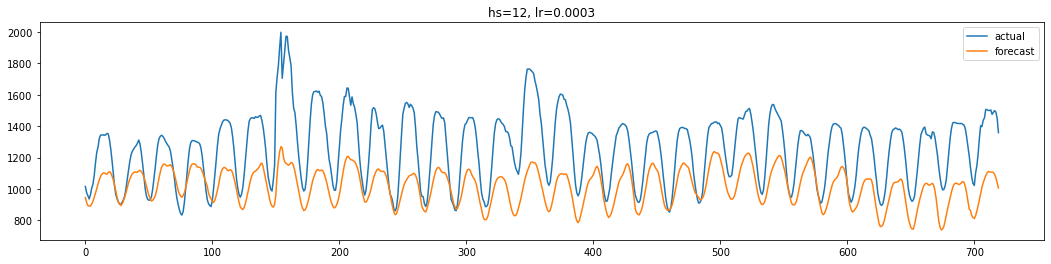

MSE...............80590.2630
RMSE..............283.8842
MAE...............242.9176
MAPE..............0.1812
R2................-0.6392              
hs=12, lr=0.0001
Early stop at 393 epoch 3.7572, test loss: 1.5008, test acc: 156.05, best acc: 155.99, time: 12m 5s (- 141m 49s), no improv.: 809


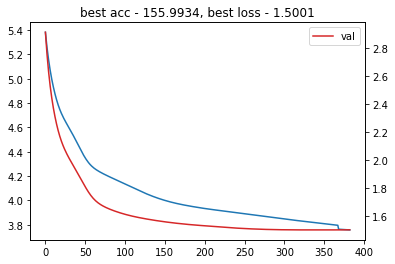

iter-12-0.0001 ->
MSE...............24334.9579
RMSE..............155.9967
MAE...............116.8345
MAPE..............0.1611
R2................0.4069              


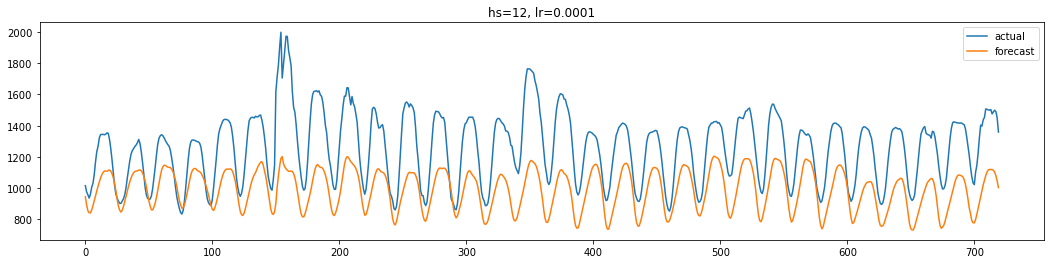

MSE...............91110.8562
RMSE..............301.8457
MAE...............266.6571
MAPE..............0.2024
R2................-0.8532              
hs=24, lr=0.003
Early stop at 96 epoch 3.4655, test loss: 2.4504, test acc: 198.79, best acc: 158.91, time: 2m 45s (- 140m 44s), no improv.: 80


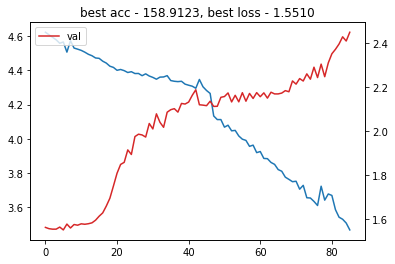

iter-24-0.003 ->
MSE...............25253.1176
RMSE..............158.9123
MAE...............118.8579
MAPE..............0.1579
R2................0.3845              


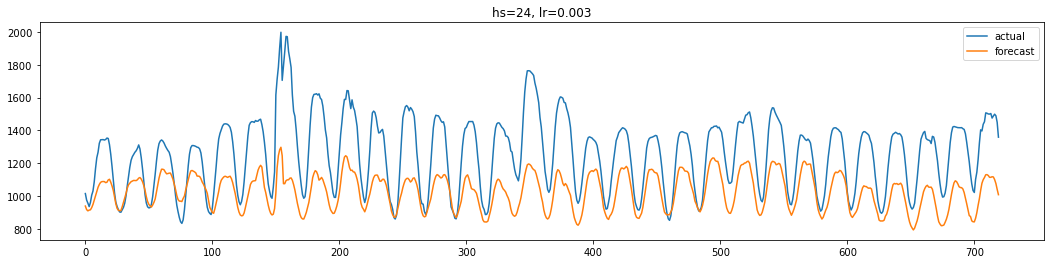

MSE...............74267.8189
RMSE..............272.5212
MAE...............231.4659
MAPE..............0.1719
R2................-0.5106              
hs=24, lr=0.001
Early stop at 170 epoch 3.0709, test loss: 1.5299, test acc: 157.28, best acc: 155.31, time: 4m 51s (- 138m 9s), no improv.: 809


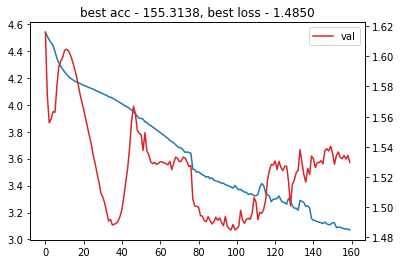

iter-24-0.001 ->
MSE...............24122.3844
RMSE..............155.3138
MAE...............115.9222
MAPE..............0.1587
R2................0.4121              


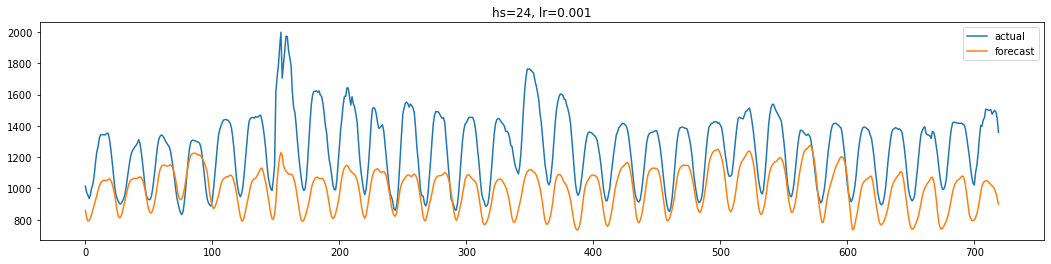

MSE...............91603.6715
RMSE..............302.6610
MAE...............263.0788
MAPE..............0.1992
R2................-0.8632              
hs=24, lr=0.0003
Early stop at 112 epoch 3.6180, test loss: 1.6802, test acc: 165.13, best acc: 152.50, time: 3m 12s (- 139m 42s), no improv.: 80


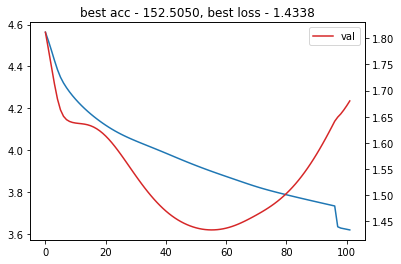

iter-24-0.0003 ->
MSE...............23257.7711
RMSE..............152.5050
MAE...............114.2352
MAPE..............0.1563
R2................0.4332              


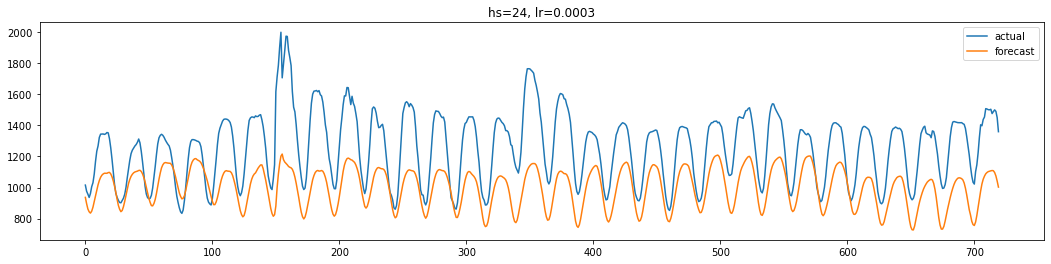

MSE...............87302.1243
RMSE..............295.4693
MAE...............258.2289
MAPE..............0.1951
R2................-0.7758              
hs=24, lr=0.0001
Early stop at 154 epoch 3.6979, test loss: 1.5265, test acc: 157.30, best acc: 156.39, time: 4m 23s (- 138m 17s), no improv.: 80


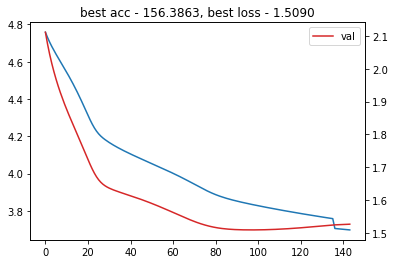

iter-24-0.0001 ->
MSE...............24456.6919
RMSE..............156.3864
MAE...............117.7188
MAPE..............0.1608
R2................0.4040              


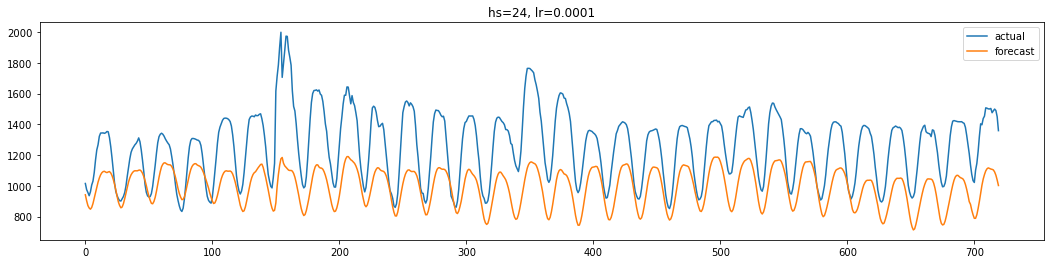

MSE...............90887.1451
RMSE..............301.4749
MAE...............263.3466
MAPE..............0.1985
R2................-0.8487              
hs=32, lr=0.003
Early stop at 89 epoch 3.5004, test loss: 1.8711, test acc: 174.44, best acc: 159.44, time: 2m 43s (- 150m 16s), no improv.: 80


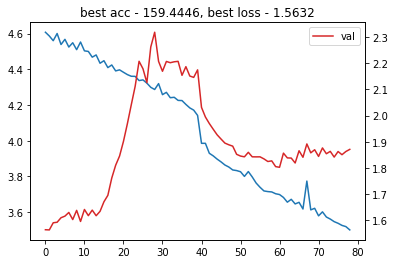

iter-32-0.003 ->
MSE...............25422.5718
RMSE..............159.4446
MAE...............119.5015
MAPE..............0.1590
R2................0.3804              


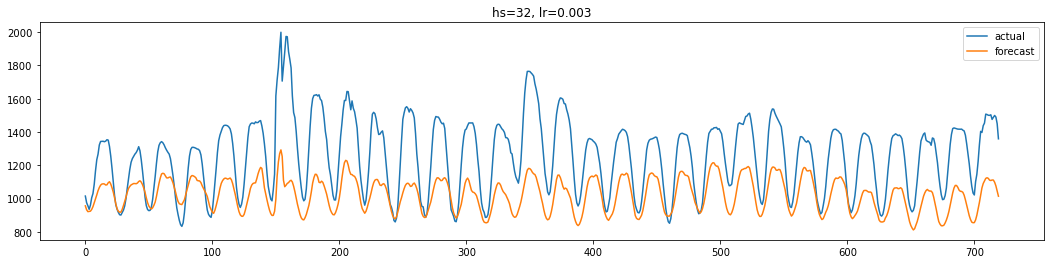

MSE...............77191.1697
RMSE..............277.8330
MAE...............235.2545
MAPE..............0.1740
R2................-0.5701              
hs=32, lr=0.001
Early stop at 109 epoch 3.3167, test loss: 2.0156, test acc: 180.47, best acc: 157.28, time: 3m 19s (- 149m 15s), no improv.: 80


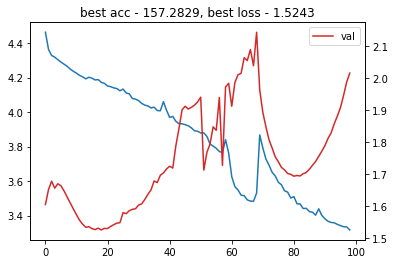

iter-32-0.001 ->
MSE...............24737.9240
RMSE..............157.2829
MAE...............117.9805
MAPE..............0.1569
R2................0.3971              


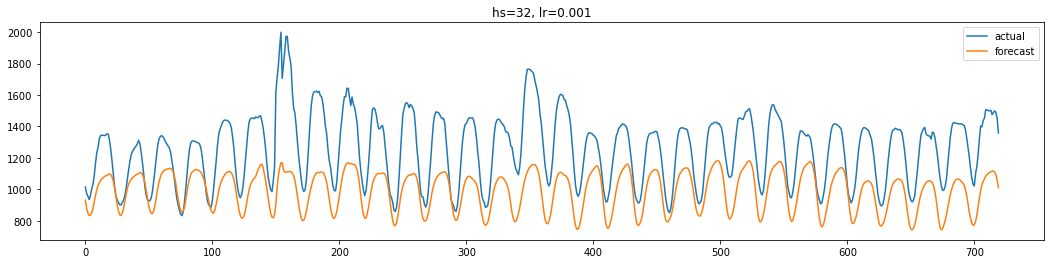

MSE...............89302.3860
RMSE..............298.8350
MAE...............263.9074
MAPE..............0.1999
R2................-0.8164              
hs=32, lr=0.0003
Early stop at 113 epoch 3.5830, test loss: 1.6217, test acc: 161.76, best acc: 152.40, time: 3m 26s (- 149m 4s), no improv.: 801


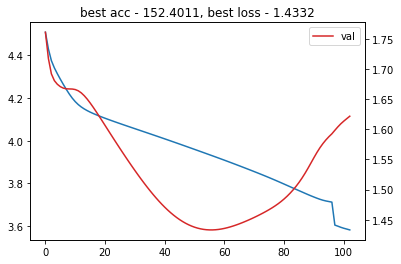

iter-32-0.0003 ->
MSE...............23226.1087
RMSE..............152.4011
MAE...............114.1374
MAPE..............0.1566
R2................0.4339              


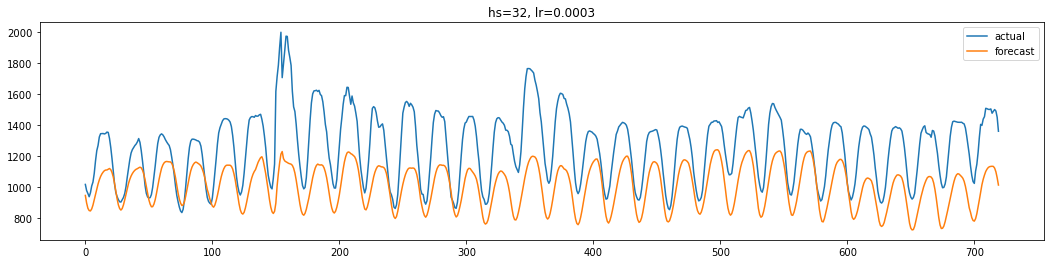

MSE...............82711.1245
RMSE..............287.5954
MAE...............251.9058
MAPE..............0.1912
R2................-0.6824              
hs=32, lr=0.0001
Early stop at 194 epoch 3.6666, test loss: 1.4791, test acc: 154.82, best acc: 154.61, time: 5m 54s (- 146m 21s), no improv.: 80


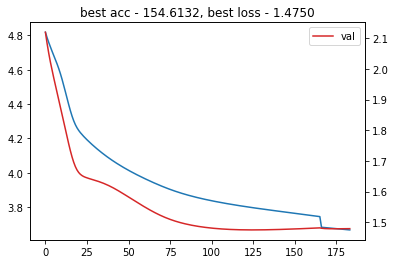

iter-32-0.0001 ->
MSE...............23905.2357
RMSE..............154.6132
MAE...............115.8751
MAPE..............0.1587
R2................0.4174              


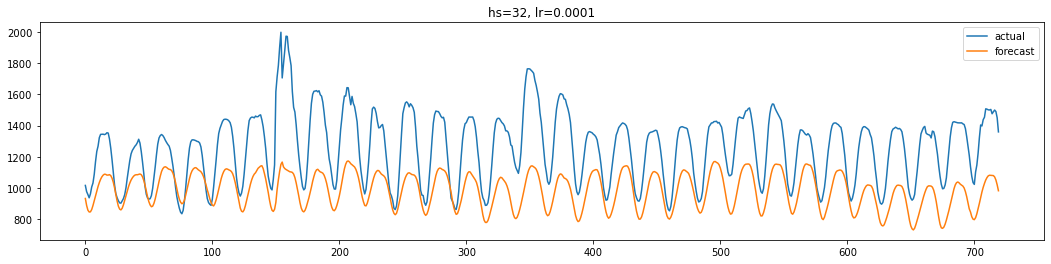

MSE...............96028.8852
RMSE..............309.8853
MAE...............271.0853
MAPE..............0.2038
R2................-0.9533              
hs=48, lr=0.003
Early stop at 91 epoch 3.7690, test loss: 2.4084, test acc: 196.89, best acc: 160.89, time: 3m 43s (- 200m 37s), no improv.: 80


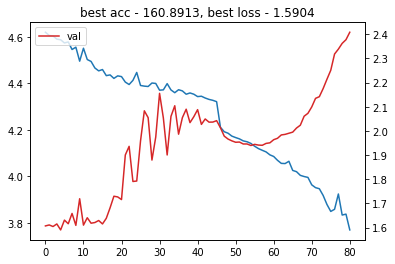

iter-48-0.003 ->
MSE...............25886.0233
RMSE..............160.8913
MAE...............120.5149
MAPE..............0.1590
R2................0.3691              


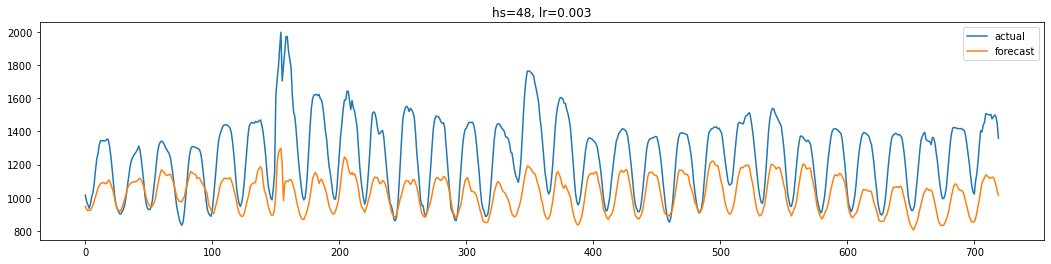

MSE...............75766.2342
RMSE..............275.2567
MAE...............233.1700
MAPE..............0.1727
R2................-0.5411              
hs=48, lr=0.001
Early stop at 90 epoch 3.4161, test loss: 1.5925, test acc: 160.85, best acc: 159.95, time: 3m 44s (- 204m 14s), no improv.: 80


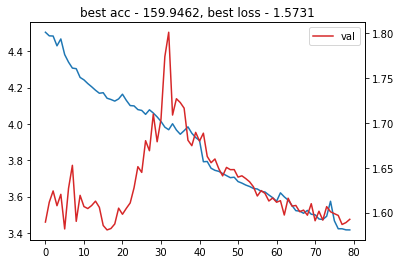

iter-48-0.001 ->
MSE...............25582.7875
RMSE..............159.9462
MAE...............120.0616
MAPE..............0.1601
R2................0.3765              


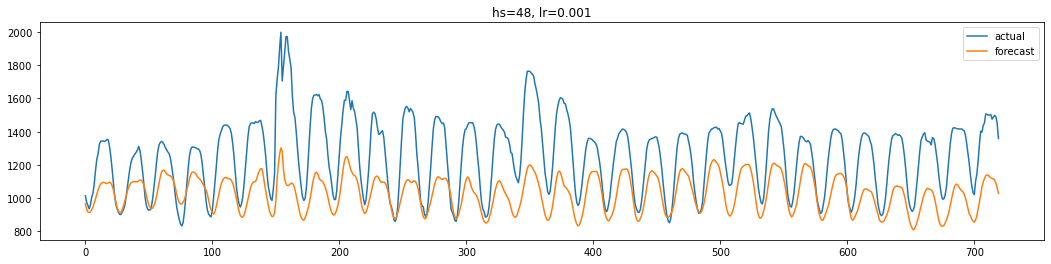

MSE...............74368.9613
RMSE..............272.7067
MAE...............230.5068
MAPE..............0.1708
R2................-0.5127              
hs=48, lr=0.0003
Early stop at 110 epoch 3.5518, test loss: 1.6631, test acc: 164.42, best acc: 151.93, time: 4m 42s (- 209m 37s), no improv.: 80


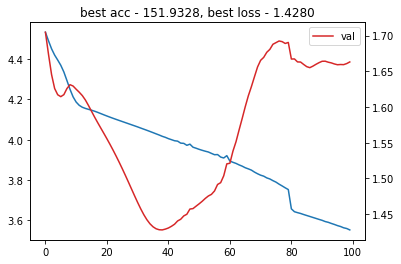

iter-48-0.0003 ->
MSE...............23083.5888
RMSE..............151.9328
MAE...............114.0899
MAPE..............0.1543
R2................0.4374              


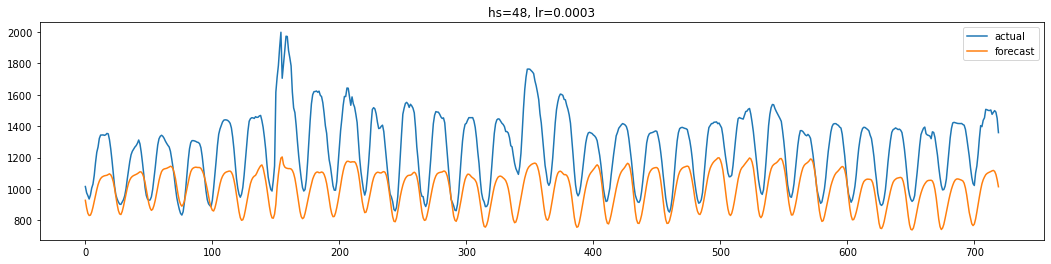

MSE...............84943.0721
RMSE..............291.4499
MAE...............255.4697
MAPE..............0.1930
R2................-0.7278              
hs=48, lr=0.0001
Early stop at 135 epoch 3.6934, test loss: 1.4536, test acc: 153.63, best acc: 151.61, time: 5m 55s (- 213m 36s), no improv.: 80


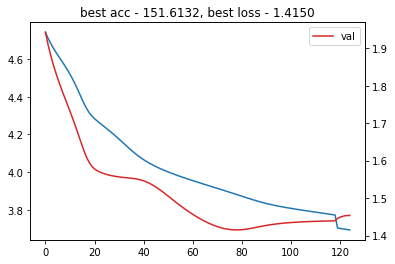

iter-48-0.0001 ->
MSE...............22986.5634
RMSE..............151.6132
MAE...............113.6612
MAPE..............0.1578
R2................0.4398              


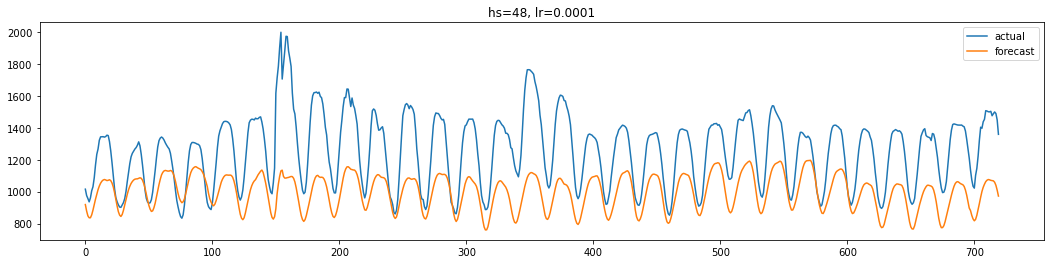

MSE...............90223.0502
RMSE..............300.3715
MAE...............259.0670
MAPE..............0.1938
R2................-0.8352              
hs=64, lr=0.003
Early stop at 95 epoch 3.5375, test loss: 2.0443, test acc: 182.44, best acc: 162.47, time: 4m 14s (- 219m 25s), no improv.: 80


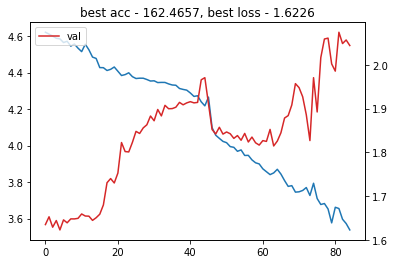

iter-64-0.003 ->
MSE...............26395.1055
RMSE..............162.4657
MAE...............121.8240
MAPE..............0.1594
R2................0.3567              


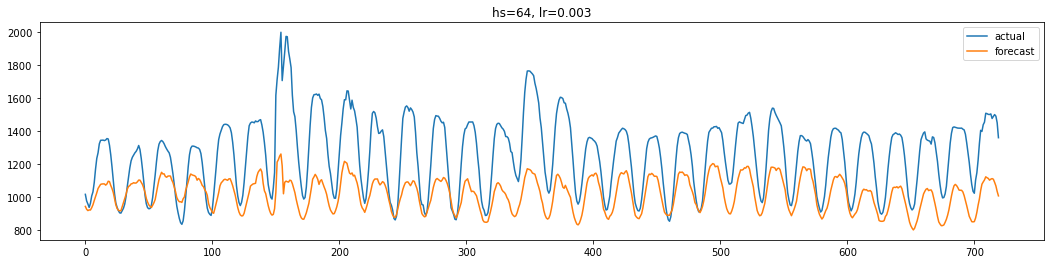

MSE...............79580.5066
RMSE..............282.1002
MAE...............239.9492
MAPE..............0.1778
R2................-0.6187              
hs=64, lr=0.001
Early stop at 110 epoch 3.2995, test loss: 2.0999, test acc: 183.44, best acc: 158.85, time: 4m 49s (- 214m 7s), no improv.: 807


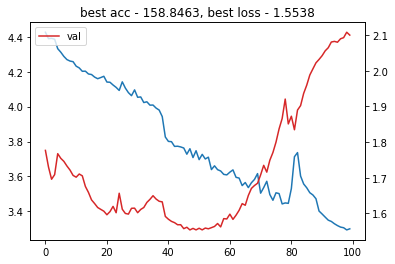

iter-64-0.001 ->
MSE...............25234.4275
RMSE..............158.8535
MAE...............118.8248
MAPE..............0.1594
R2................0.3850              


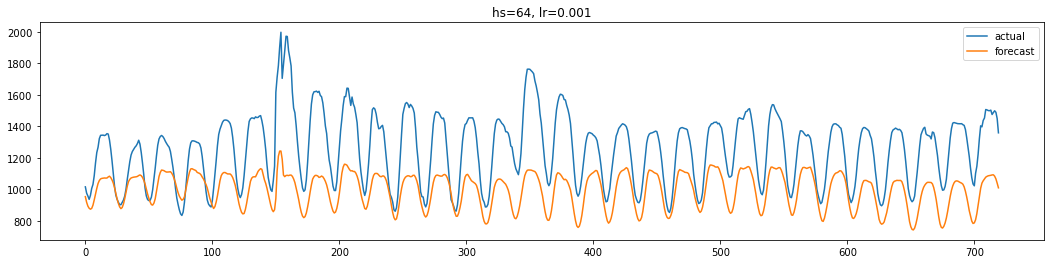

MSE...............89033.9940
RMSE..............298.3856
MAE...............261.1343
MAPE..............0.1963
R2................-0.8110              
hs=64, lr=0.0003
Early stop at 107 epoch 3.4332, test loss: 1.6646, test acc: 163.38, best acc: 156.44, time: 4m 39s (- 213m 18s), no improv.: 80


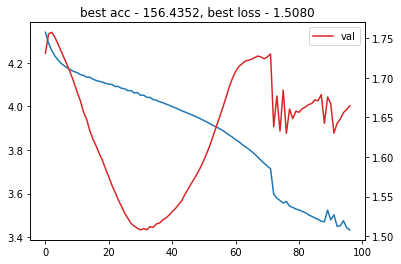

iter-64-0.0003 ->
MSE...............24471.9837
RMSE..............156.4352
MAE...............117.8086
MAPE..............0.1558
R2................0.4036              


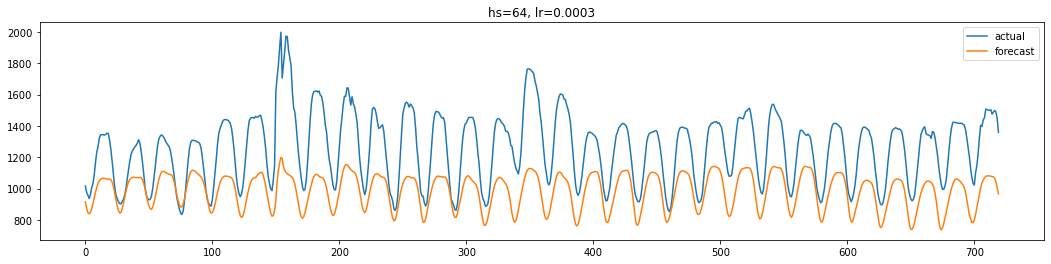

MSE...............92992.0428
RMSE..............304.9460
MAE...............269.6756
MAPE..............0.2035
R2................-0.8915              
hs=64, lr=0.0001
Early stop at 144 epoch 3.6044, test loss: 1.7136, test acc: 165.65, best acc: 151.58, time: 6m 19s (- 213m 10s), no improv.: 80


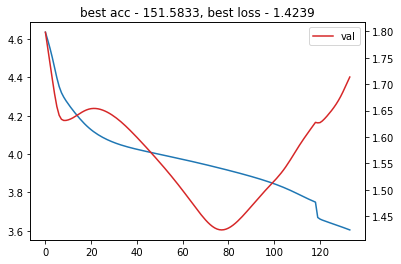

iter-64-0.0001 ->
MSE...............22984.1873
RMSE..............151.6054
MAE...............113.9257
MAPE..............0.1564
R2................0.4398              


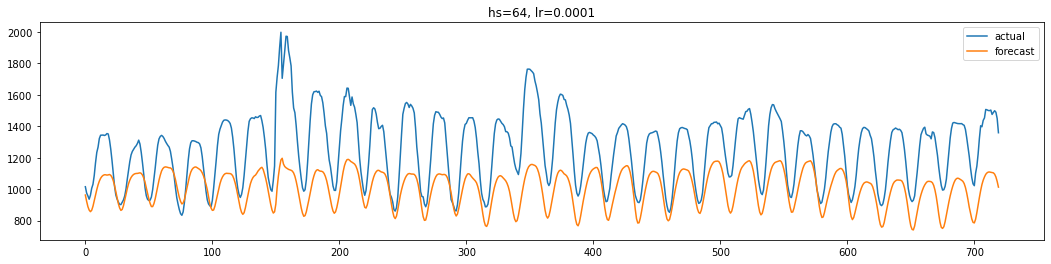

MSE...............83415.2881
RMSE..............288.8170
MAE...............250.6053
MAPE..............0.1880
R2................-0.6967              
hs=12, lr=0.003 .... [25309.14, 159.09, 119.28, 0.16, 0.38]
hs=12, lr=0.001 .... [23711.82, 153.99, 115.24, 0.16, 0.42]
hs=12, lr=0.0003 .... [22900.11, 151.33, 113.13, 0.16, 0.44]
hs=12, lr=0.0001 .... [24334.96, 156.0, 116.83, 0.16, 0.41]
hs=24, lr=0.003 .... [25253.12, 158.91, 118.86, 0.16, 0.38]
hs=24, lr=0.001 .... [24122.38, 155.31, 115.92, 0.16, 0.41]
hs=24, lr=0.0003 .... [23257.77, 152.5, 114.24, 0.16, 0.43]
hs=24, lr=0.0001 .... [24456.69, 156.39, 117.72, 0.16, 0.4]
hs=32, lr=0.003 .... [25422.57, 159.44, 119.5, 0.16, 0.38]
hs=32, lr=0.001 .... [24737.92, 157.28, 117.98, 0.16, 0.4]
hs=32, lr=0.0003 .... [23226.11, 152.4, 114.14, 0.16, 0.43]
hs=32, lr=0.0001 .... [23905.24, 154.61, 115.88, 0.16, 0.42]
hs=48, lr=0.003 .... [25886.02, 160.89, 120.51, 0.16, 0.37]
hs=48, lr=0.001 .... [25582.79, 159.95, 120.06, 0.16, 0.38]
hs=48, lr=0.

In [21]:
# итерирование по гиперпараметрам

dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=df[['ats', 'index', 'load_planned_sobr', 'day_of_week', 'day']], 
                                                                          val_len=0.2, 
                                                                          test_len=720, 
                                                                          seq_length=168, 
                                                                          shift=720, 
                                                                          batch_size=256,
                                                                          print_shapes=True)
print('\n')

hid = [12, 24, 32, 48, 64]
lr  = [3e-3, 1e-3, 3e-4, 1e-4]
pat = 80
iter_log = 1
show_plot = True

val_results, test_results = {}, {}

for hidden_size in hid:
    for learning_rate in lr:
        iter_name = f'hs={hidden_size}, lr={learning_rate}'
        print(iter_name)
        
        seed_everything(SEED)

        num_epochs    = 5000
        learning_rate = learning_rate
        input_size    = feature_dim

        model = RNN(RNN_cell=nn.LSTM,
                    hidden_size=hidden_size,
                    num_layers=1,
                    dropout=0,
                    in_size=input_size, 
                    out_size=1, 
                    bidirectional=False).to(device)

        criterion = torch.nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=pat/2, min_lr=1e-5)

        model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
              dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
              lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
              iter_log=iter_log, show_plot=show_plot, step_size=None, one_line_log=True)

        # # #
        
        print(f'iter-{hidden_size}-{learning_rate} ->')
        
        model.eval()
        y_act, y_hat = batch_predict(model=model, dataloader=dataset_val)
        y_hat = unscale(y_hat, feature_dim, scaler)
        y_act = unscale(y_act, feature_dim, scaler)

        val_scores = metric(y_act, y_hat, log=True);

        # # #

        y_act, y_hat = batch_predict(model=model, dataloader=dataset_test)
        y_hat = unscale(y_hat, feature_dim, scaler)
        y_act = unscale(y_act, feature_dim, scaler)
        plt.figure(figsize=(18,4))
        plt.plot(y_act, label='actual')
        plt.plot(y_hat, label='forecast')
        plt.legend()
        plt.title(iter_name)
        plt.show()

        test_scores = metric(y_act, y_hat, log=True)
        
        val_results.update({iter_name : val_scores})
        test_results.update({iter_name : test_scores})

for key, value in val_results.items():
    print(key, '....', [round(x,2) for x in value])
print('\n')
for key, value in test_results.items():
    print(key, '....', [round(x,2) for x in value])

### Feture selector

In [18]:
np.set_printoptions(formatter={'float_kind' : "{:.3f}".format})

def train_model(data):
    print(f'\n{data.columns=}')
    pat = 50
    iter_log = 1
    dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=data, 
                                                                              val_len=0.2, 
                                                                              test_len=720, 
                                                                              seq_length=168, 
                                                                              shift=720, 
                                                                              batch_size=256,
                                                                              print_shapes=False)

    seed_everything(SEED)
    num_epochs    = 1000
    learning_rate = 1e-3
    input_size    = feature_dim
    model = RNN(RNN_cell=nn.LSTM,
                hidden_size=24,
                num_layers=1,
                dropout=0,
                in_size=input_size, 
                out_size=1, 
                bidirectional=False).to(device)
    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=pat/2, min_lr=1e-5)
    best_model = copy.deepcopy(model.state_dict())

    model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
                  dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
                  lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
                  iter_log=iter_log, show_plot=False, step_size=None, one_line_log=True)
    
    model.eval()
    yact, yhat = batch_predict(model=model, dataloader=dataset_val)
    metrics = metric(unscale(yhat, feature_dim, scaler), 
                     unscale(yact, feature_dim, scaler))
    
    return model, metrics

def iterate(data):
    score = {}
    for i in main_features.columns:
        X = data.copy()
        X[i] = main_features[[i]]
        _, metrics = train_model(X)
        score.update({i : metrics[1]})
        results.loc[' + '.join(data.columns.tolist()), i] = metrics[1]
        print(f'....{i} -> RMSE={metrics[1]:.2f}')
    feature = min(score, key=score.get)
    print(f'Best feature - {feature}, metric improvment - {(score[feature]-prev_score):.3f} (acc = {score[feature]:.3f})')
    return feature, score[feature]

In [19]:
df.columns

Index(['rsv', 'ats', 'price', 'month', 'day', 'day_of_week', 'year', 'index',
       'workday', 'weekend', 'shortday', 'holiday', 'T2M', 'load_planned_sobr',
       'generate_planned_sobr'],
      dtype='object')

In [20]:
import warnings
warnings.filterwarnings('ignore')

main_features = df.drop(columns=['price', 'rsv']).copy()
data = pd.DataFrame(main_features.pop('ats'))
# data = pd.concat([main_features.pop(x) for x in ['price_smooth', 'index']], axis=1)

_, init_score = train_model(data)
init_score = init_score[1]
prev_score = init_score
print(f'Initial score = {prev_score:.3f}')

results = pd.DataFrame()
results.loc[' + '.join(data.columns.tolist()), ' + '.join(data.columns.tolist())] = prev_score
epoch = len(main_features.columns)
hold = 0
for f in range(1,epoch+1):
    start = time.time()
    best_feature, best_score = iterate(data)
    if best_score < prev_score:
        hold = 0
        data[best_feature] = main_features.pop(best_feature)
        prev_score = best_score
        best_x = data.copy()
        print(f'add - {best_feature}\n')
    elif hold < 0:
        hold += 1
        data[best_feature] = main_features.pop(best_feature)
        print(f'negative add - {best_feature}\n')
    else:
        break
print('Picked features ->', [c for c in best_x.columns], '\n')
# # # # # # # # # # # # # # # # # # # # # #

_, metrics = train_model(best_x)

print(metrics)


data.columns=Index(['ats'], dtype='object')
Early stop at 75 epoch 4.1974, test loss: 2.1691, test acc: 186.92, best acc: 170.86, time: 2m 5s (- 25m 42s), no improv.: 506
Initial score = 170.859

data.columns=Index(['ats', 'month'], dtype='object')
Early stop at 60 epoch 4.1097, test loss: 1.8575, test acc: 173.42, best acc: 165.80, time: 1m 37s (- 25m 21s), no improv.: 50
....month -> RMSE=165.80

data.columns=Index(['ats', 'day'], dtype='object')
Early stop at 67 epoch 4.1761, test loss: 2.0357, test acc: 181.43, best acc: 170.49, time: 1m 48s (- 25m 10s), no improv.: 50
....day -> RMSE=170.49

data.columns=Index(['ats', 'day_of_week'], dtype='object')
Early stop at 64 epoch 4.1599, test loss: 1.9517, test acc: 177.45, best acc: 170.42, time: 1m 44s (- 25m 22s), no improv.: 50
....day_of_week -> RMSE=170.42

data.columns=Index(['ats', 'year'], dtype='object')
Early stop at 87 epoch 4.0435, test loss: 2.4761, test acc: 198.97, best acc: 165.12, time: 2m 21s (- 24m 43s), no improv.: 5

Early stop at 213 epoch 3.0582, test loss: 1.4750, test acc: 154.82, best acc: 153.81, time: 5m 56s (- 21m 57s), no improv.: 50
....day -> RMSE=153.81

data.columns=Index(['ats', 'index', 'load_planned_sobr', 'day_of_week', 'year'], dtype='object')
Early stop at 85 epoch 3.6283, test loss: 2.0070, test acc: 180.04, best acc: 156.40, time: 2m 21s (- 25m 28s), no improv.: 50
....year -> RMSE=156.40

data.columns=Index(['ats', 'index', 'load_planned_sobr', 'day_of_week', 'workday'], dtype='object')
Early stop at 60 epoch 3.7461, test loss: 1.6439, test acc: 163.33, best acc: 158.02, time: 1m 40s (- 26m 12s), no improv.: 51
....workday -> RMSE=158.02

data.columns=Index(['ats', 'index', 'load_planned_sobr', 'day_of_week', 'weekend'], dtype='object')
Early stop at 101 epoch 3.4918, test loss: 1.5776, test acc: 160.02, best acc: 155.08, time: 2m 48s (- 25m 3s), no improv.: 50
....weekend -> RMSE=155.08

data.columns=Index(['ats', 'index', 'load_planned_sobr', 'day_of_week', 'shortday'], dtyp

<AxesSubplot:>

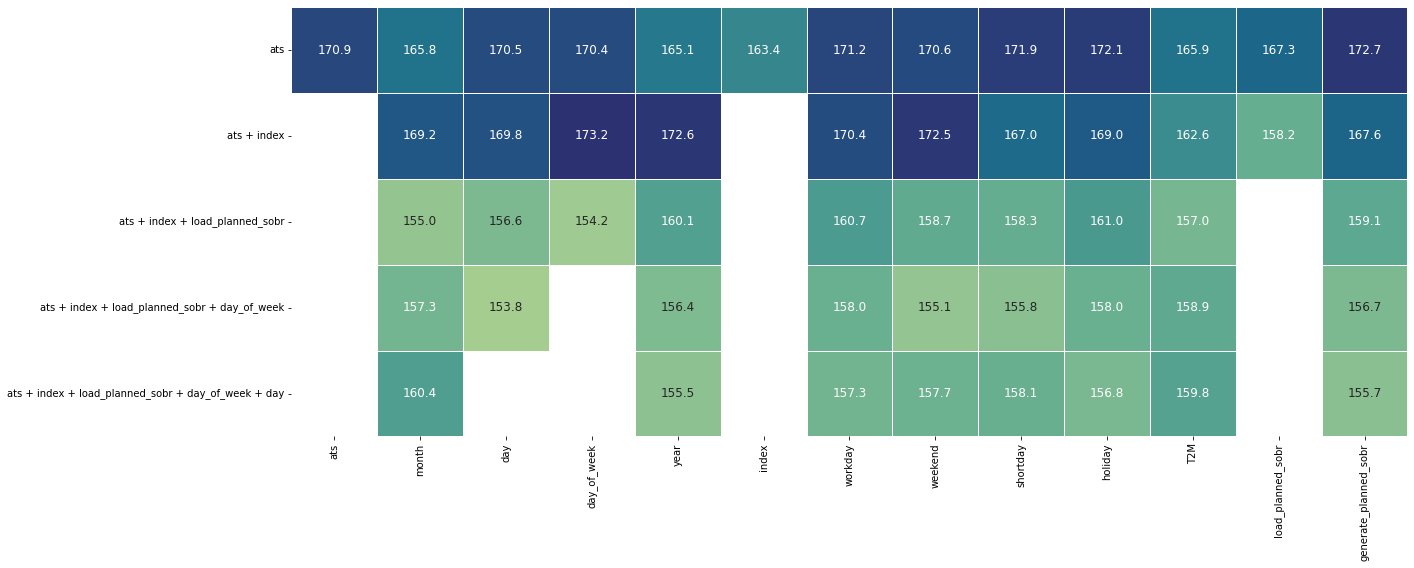

In [21]:
import seaborn as sns

plt.figure(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(results, cmap=cmap, square=True, linewidths=.5, cbar=False, annot=True, fmt=".1f", annot_kws={"size":12})